In [157]:
import os
# Supress Warnings
import warnings

from tqdm import tqdm

warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
import pandas as pd
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load

# LOADING Training Data


In [158]:
# Calculate NDVI
training_data = pd.read_csv("../data_test/training_data_uhi_index.csv")
training_data.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


In [159]:
training_data.rename(columns={"Latitude": "latitude", "Longitude": "longitude"}, inplace=True)

In [160]:
print(training_data['datetime'].min(), training_data['datetime'].max())

24-07-2021 15:01 24-07-2021 15:59


## Data Preparation

In [161]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [162]:
# Define the time window
time_window = "2021-06-01/2021-09-01"

In [163]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [164]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 10


In [165]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [166]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326

In [167]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326",  # Latitude-Longitude
    resolution=scale,  # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [168]:
df = data.to_dataframe().reset_index()
print(df.head())

    latitude  longitude                    time  spatial_ref   B01   B02  \
0  40.880031 -74.010016 2021-06-06 15:38:09.024         4326   734   832   
1  40.880031 -74.010016 2021-06-16 15:38:09.024         4326   647   634   
2  40.880031 -74.010016 2021-06-24 15:49:11.024         4326   722   717   
3  40.880031 -74.010016 2021-06-29 15:48:09.024         4326   627   583   
4  40.880031 -74.010016 2021-07-06 15:38:09.024         4326  1813  1740   

    B03   B04   B05   B06   B07   B08   B8A   B11   B12  
0   951   861  1097  2311  2549  2264  2811  1897  1259  
1   802   793   988  2264  2728  2204  2873  1814  1224  
2   935   885  1147  2135  2198  1738  2579  1754  1211  
3   710   666   924  1719  2013  2026  2598  1704  1139  
4  1628  1512  1699  1944  2023  1958  2076  1441  1161  


In [169]:
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.strftime('%d-%m-%Y %H:%M')
display(df)
training_data['datetime'] = pd.to_datetime(training_data['datetime'], format='%d-%m-%Y %H:%M')

,latitude,longitude,time,spatial_ref,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,40.880031,-74.010016,06-06-2021 15:38,4326,734,832,951,861,1097,2311,2549,2264,2811,1897,1259
1,40.880031,-74.010016,16-06-2021 15:38,4326,647,634,802,793,988,2264,2728,2204,2873,1814,1224
2,40.880031,-74.010016,24-06-2021 15:49,4326,722,717,935,885,1147,2135,2198,1738,2579,1754,1211
3,40.880031,-74.010016,29-06-2021 15:48,4326,627,583,710,666,924,1719,2013,2026,2598,1704,1139
4,40.880031,-74.010016,06-07-2021 15:38,4326,1813,1740,1628,1512,1699,1944,2023,1958,2076,1441,1161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24196075,40.750045,-73.859998,14-07-2021 15:49,4326,1637,1582,1748,1666,1878,2120,2224,2064,2342,2245,1965
24196076,40.750045,-73.859998,16-07-2021 15:38,4326,1133,1322,1446,1498,1632,1837,1807,1832,1981,2161,2006
24196077,40.750045,-73.859998,24-07-2021 15:49,4326,1182,1220,1398,1418,1530,1557,1903,1788,1797,1909,1721
24196078,40.750045,-73.859998,31-07-2021 15:39,4326,1190,1394,1548,1566,1646,1888,1862,1840,1829,2102,1858


In [170]:
df_filtered = df[
    (df['time'] <= training_data['datetime'].max()) &
    (df['time'] >= training_data['datetime'].min())
]
display(df_filtered)
df_filtered.to_csv('../data_test_test/df_filtered_date.csv', index=False) if not os.path.exists('../data_test/df_filtered_date.csv') else None


TypeError: '<=' not supported between instances of 'str' and 'Timestamp'

In [78]:
# Calculate NDVI and MNDWI for each pixel
# Calculate NDVI
ndvi = (df_filtered.B08 - df_filtered.B04) / (df_filtered.B08 + df_filtered.B04)

# Calculate MNDWI
mndwi = (df_filtered.B03 - df_filtered.B11) / (df_filtered.B03 + df_filtered.B11)

# Add NDVI and MNDWI to the dataset
df_filtered = df_filtered.assign(NDVI=ndvi, MNDWI=mndwi)

# Inspect the updated dataset
print(df_filtered)
df_filtered.to_csv('../data_test/df_NDVI_MNDWI.csv', index=False) if not os.path.exists('../data_test/df_NDVI_MNDWI.csv') else None

           latitude  longitude              time  spatial_ref   B01   B02  \
7         40.880031 -74.010016  24-07-2021 15:49         4326   666   639   
17        40.880031 -74.009926  24-07-2021 15:49         4326   666   639   
27        40.880031 -74.009837  24-07-2021 15:49         4326   666   395   
37        40.880031 -74.009747  24-07-2021 15:49         4326   666   562   
47        40.880031 -74.009657  24-07-2021 15:49         4326   710   919   
...             ...        ...               ...          ...   ...   ...   
24196037  40.750045 -73.860358  24-07-2021 15:49         4326  1175  1412   
24196047  40.750045 -73.860268  24-07-2021 15:49         4326  1175   980   
24196057  40.750045 -73.860178  24-07-2021 15:49         4326  1182  1202   
24196067  40.750045 -73.860088  24-07-2021 15:49         4326  1182  1220   
24196077  40.750045 -73.859998  24-07-2021 15:49         4326  1182  1220   

           B03   B04   B05   B06   B07   B08   B8A   B11   B12       NDVI  

In [95]:
# Rename columns in training_data to match df_filtered
training_data.rename(columns={"Latitude": "latitude", "Longitude": "longitude"}, inplace=True)
training_data.reset_index(drop=True, inplace=True)
df_filtered.reset_index(drop=True, inplace=True)

# Ensure latitude and longitude are of the same data type
training_data["latitude"] = training_data["latitude"].astype(float)
training_data["longitude"] = training_data["longitude"].astype(float)

df_filtered["latitude"] = df_filtered["latitude"].astype(float)
df_filtered["longitude"] = df_filtered["longitude"].astype(float)

print(training_data.dtypes)
print(df_filtered.dtypes)


# Perform the join (left join example)
merged_data = pd.merge(
    training_data,       # Left dataframe
    df_filtered,         # Right dataframe
    on=["latitude", "longitude"],  # Join keys
    how="left"           # Join type (use 'inner', 'outer', or 'right' if needed)
)

# Inspect the merged data


longitude    float64
latitude     float64
datetime      object
UHI Index    float64
dtype: object
latitude       float64
longitude      float64
time            object
spatial_ref      int32
B01             uint16
B02             uint16
B03             uint16
B04             uint16
B05             uint16
B06             uint16
B07             uint16
B08             uint16
B8A             uint16
B11             uint16
B12             uint16
NDVI           float64
MNDWI          float64
dtype: object


,longitude,latitude,datetime,UHI Index


In [101]:
# Check for null values in the key columns
print("Null values in training_data:")
print(training_data[["latitude", "longitude"]].isnull().sum())

print("\nNull values in df_filtered:")
print(df_filtered[["latitude", "longitude"]].isnull().sum())

# Check for common keys by performing an inner join
common_keys = pd.merge(
    training_data[["latitude", "longitude"]],
    df_filtered[["latitude", "longitude"]],
    on=["latitude", "longitude"],
    how="inner"
)

print(f"\nNumber of matching keys: {len(common_keys)}")


Null values in training_data:
latitude     0
longitude    0
dtype: int64

Null values in df_filtered:
latitude     0
longitude    0
dtype: int64

Number of matching keys: 0


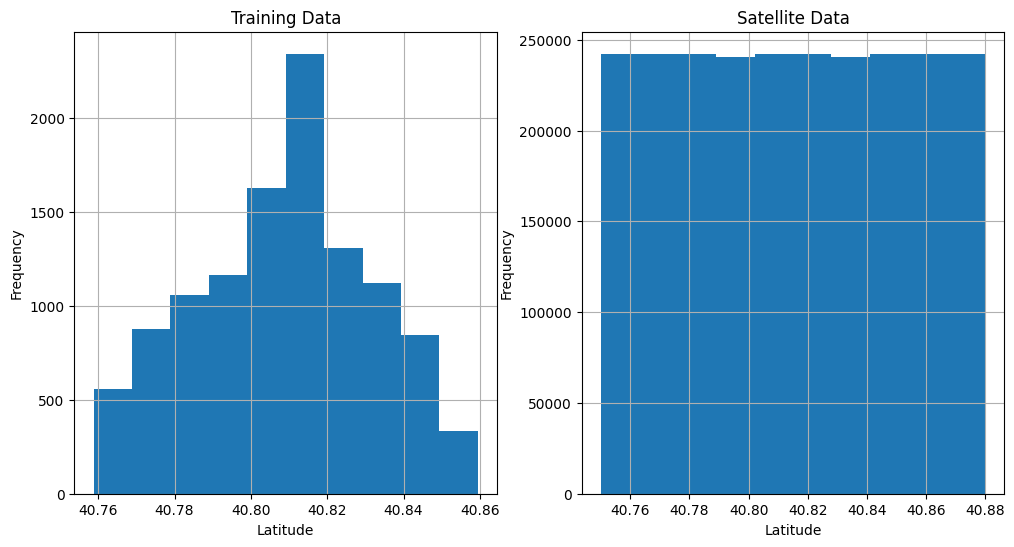

In [100]:
## histogram of latitude for training data and df_filtered separetely side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
training_data["latitude"].hist(ax=ax[0])
ax[0].set_title("Training Data")
ax[0].set_xlabel("Latitude")
ax[0].set_ylabel("Frequency")

df_filtered["latitude"].hist(ax=ax[1])
ax[1].set_title("Satellite Data")
ax[1].set_xlabel("Latitude")
ax[1].set_ylabel("Frequency")

plt.show()



In [106]:
# Function to extract features for a point from a pandas DataFrame
def extract_features_from_dataframe(lat, lon, df_filtered):
    # Calculate distances between the point and all rows in df_filtered
    df_filtered["distance"] = np.sqrt(
        (df_filtered["Latitude"] - lat) ** 2 + (df_filtered["Longitude"] - lon) ** 2
    )
    # Find the closest point
    closest_row = df_filtered.loc[df_filtered["distance"].idxmin()]
    # Return the feature values as a dictionary
    return closest_row.to_dict()

# Rename columns to match if needed
df_filtered.rename(columns={"latitude": "Latitude", "longitude": "Longitude"}, inplace=True)

# Iterate over training_data and extract features
features = []
for _, row in training_data.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]
    features.append(extract_features_from_dataframe(lat, lon, df_filtered))

# Combine extracted features with training_data
extracted_features = pd.DataFrame(features)
training_data_with_features = pd.concat([training_data.reset_index(drop=True), extracted_features.reset_index(drop=True)], axis=1)

# Save the enhanced training data to a CSV file
training_data_with_features.to_csv("../data_test/training_data_with_features.csv", index=False) if not os.path.exists("../data_test/training_data_with_features.csv") else None

   Longitude   Latitude          datetime  UHI Index   Latitude  Longitude  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289  40.813106 -73.909136   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289  40.813017 -73.909226   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798  40.813017 -73.909226   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798  40.812927 -73.909226   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634  40.812837 -73.909226   

               time  spatial_ref  B01   B02  ...   B05   B06   B07   B08  \
0  24-07-2021 15:49         4326  846  1042  ...  1272  1502  1605  1906   
1  24-07-2021 15:49         4326  846   583  ...  1054  1668  2097  2190   
2  24-07-2021 15:49         4326  846   583  ...  1054  1668  2097  2190   
3  24-07-2021 15:49         4326  846   581  ...  1054  1668  2097  2182   
4  24-07-2021 15:49         4326  846   655  ...  1021  1728  1943  2112   

    B8A   B11   B12      NDVI      MNDWI  distance  
0  1638  1487  1265  

In [132]:
from scipy.ndimage import uniform_filter
import xarray as xr

# Define a function to calculate mean values within a radius
def compute_radius_mean(array, radius=10):
    kernel_size = int(radius / (10 / 111320))  # Convert radius (meters) to pixel size
    return uniform_filter(array, size=kernel_size, mode="constant")

training_data_with_features["NDVI_mean_10m"] = compute_radius_mean(training_data_with_features["NDVI"].values, radius=10)
training_data_with_features["NDVI_mean_50m"] = (
    compute_radius_mean(training_data_with_features["NDVI"].values, radius=50)
    - training_data_with_features["NDVI_mean_10m"]
)
training_data_with_features["NDVI_mean_100m"] = (
    compute_radius_mean(training_data_with_features["NDVI"].values, radius=100)
    - training_data_with_features["NDVI_mean_50m"]
)

# Calculate MNDWI mean for different radii
training_data_with_features["MNDWI_mean_10m"] = compute_radius_mean(training_data_with_features["MNDWI"].values, radius=10)
training_data_with_features["MNDWI_mean_50m"] = (
    compute_radius_mean(training_data_with_features["MNDWI"].values, radius=50)
    - training_data_with_features["MNDWI_mean_10m"]
)
training_data_with_features["MNDWI_mean_100m"] = (
    compute_radius_mean(training_data_with_features["MNDWI"].values, radius=100)
    - training_data_with_features["MNDWI_mean_50m"]
)

# Save to CSV
# training_data_with_features.to_csv("../data_test/training_data_with_features.csv", index=False) if not os.path.exists("../data_test/training_data_with_features.csv") else None


In [153]:
training_data_with_features

,Longitude,Latitude,datetime,UHI Index,Latitude,Longitude,time,spatial_ref,B01,B02,...,NDVI_mean_100m,MNDWI_mean_10m,MNDWI_mean_50m,MNDWI_mean_100m,NDVI_count_10m,NDVI_count_50m,NDVI_count_100m,MNDWI_count_10m,MNDWI_count_50m,MNDWI_count_100m
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,40.813106,-73.909136,24-07-2021 15:49,4326,846,1042,...,0.306816,1.928807,-1.543045,1.735926,4472.0,0.0,4472.0,11225.0,0.0,11225.0
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,40.813017,-73.909226,24-07-2021 15:49,4326,846,583,...,0.306816,1.928807,-1.543045,1.735926,4472.0,0.0,4472.0,11225.0,0.0,11225.0
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,40.813017,-73.909226,24-07-2021 15:49,4326,846,583,...,0.306816,1.928807,-1.543045,1.735926,4472.0,0.0,4472.0,11225.0,0.0,11225.0
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,40.812927,-73.909226,24-07-2021 15:49,4326,846,581,...,0.306816,1.928807,-1.543045,1.735926,4472.0,0.0,4472.0,11225.0,0.0,11225.0
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,40.812837,-73.909226,24-07-2021 15:49,4326,846,655,...,0.306816,1.928807,-1.543045,1.735926,4472.0,0.0,4472.0,11225.0,0.0,11225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,40.790289,-73.957016,24-07-2021 15:49,4326,481,747,...,0.306816,1.928807,-1.543045,1.735926,4472.0,0.0,4472.0,11225.0,0.0,11225.0
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,40.790289,-73.957106,24-07-2021 15:49,4326,481,540,...,0.306816,1.928807,-1.543045,1.735926,4472.0,0.0,4472.0,11225.0,0.0,11225.0
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,40.790289,-73.957106,24-07-2021 15:49,4326,481,540,...,0.306816,1.928807,-1.543045,1.735926,4472.0,0.0,4472.0,11225.0,0.0,11225.0
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,40.790289,-73.957106,24-07-2021 15:49,4326,481,540,...,0.306816,1.928807,-1.543045,1.735926,4472.0,0.0,4472.0,11225.0,0.0,11225.0


In [ ]:
import matplotlib.pyplot as plt

# List of count columns to plot
count_columns = [
    "NDVI_count_10m", "NDVI_count_50m", "NDVI_count_100m",
    "MNDWI_count_10m", "MNDWI_count_50m", "MNDWI_count_100m"
]

# Define the grid size for subplots
n_cols = 3
n_rows = -(-len(count_columns) // n_cols)  # Ceiling division

# Create the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(count_columns):
    ax = axes[i]
    training_data_with_features[col].plot.hist(ax=ax, bins=30, alpha=0.7, edgecolor='black')
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel("Count")
    ax.set_ylabel("Frequency")

# Hide any empty subplots
for j in range(len(count_columns), len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


In [143]:
training_data_with_features.to_csv("../data_test/training_data_with_features&counts.csv", index=False) if not os.path.exists("../data_test/training_data_with_features&counts.csv") else None

# LOADING DATA

In [ ]:
# Load the training data from csv file and display the first few rows to inspect the data
training_data = pd.read_csv("Training_data_uhi_index.csv")
training_data.head()

In [107]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [108]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [109]:
# Define the time window
time_window = "2021-06-01/2021-09-01"

In [110]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [111]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 10


In [112]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [113]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326

In [114]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326",  # Latitude-Longitude
    resolution=scale,  # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [125]:
from tqdm import tqdm

# Extract latitudes and longitudes from training_data
latitudes = training_data["Latitude"].values
longitudes = training_data["Longitude"].values

# Initialize lists to store extracted band values
B01_values, B04_values, B06_values, B08_values = [], [], [], []

# Loop through each latitude and longitude
for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Extract values for each band using the correct dimensions
    B01_value = data["B01"].sel(longitude=lon, latitude=lat, method="nearest").values
    B01_values.append(B01_value)

    B04_value = data["B04"].sel(longitude=lon, latitude=lat, method="nearest").values
    B04_values.append(B04_value)

    B06_value = data["B06"].sel(longitude=lon, latitude=lat, method="nearest").values
    B06_values.append(B06_value)

    B08_value = data["B08"].sel(longitude=lon, latitude=lat, method="nearest").values
    B08_values.append(B08_value)

# Add extracted band values to the training_data DataFrame
training_data["B01"] = B01_values
training_data["B04"] = B04_values
training_data["B06"] = B06_values
training_data["B08"] = B08_values

# Save the updated DataFrame to a CSV file
training_data.to_csv("training_data_with_selected_bands.csv", index=False)

# Display the result
print(training_data.head())


Mapping values:   0%|          | 13/11229 [01:30<21:44:21,  6.98s/it]


KeyboardInterrupt: 

In [126]:
from tqdm import tqdm

# Extract latitudes and longitudes from training_data
latitudes = training_data["Latitude"].values
longitudes = training_data["Longitude"].values

# Initialize a dictionary to store band values
available_bands = [band for band in data.data_vars.keys() if band.startswith("B")]
band_values = {band: [] for band in available_bands}  # Only include available bands

# Loop through each latitude and longitude
for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Extract values for each available band
    for band in band_values.keys():
        band_value = data.sel(longitude=lon, latitude=lat, method="nearest")[band].values
        band_values[band].append(band_value)

# Add extracted band values to the training_data DataFrame
for band, values in band_values.items():
    training_data[band] = values

# Save the updated DataFrame to a CSV file
training_data.to_csv("training_data_with_available_bands.csv", index=False) if not os.path.exists("training_data_with_available_bands.csv") else None

# Display the result
print(training_data.head())


Mapping values:   0%|          | 53/11229 [21:08<74:18:46, 23.94s/it] 


WarpOperationError: Chunk and warp failed

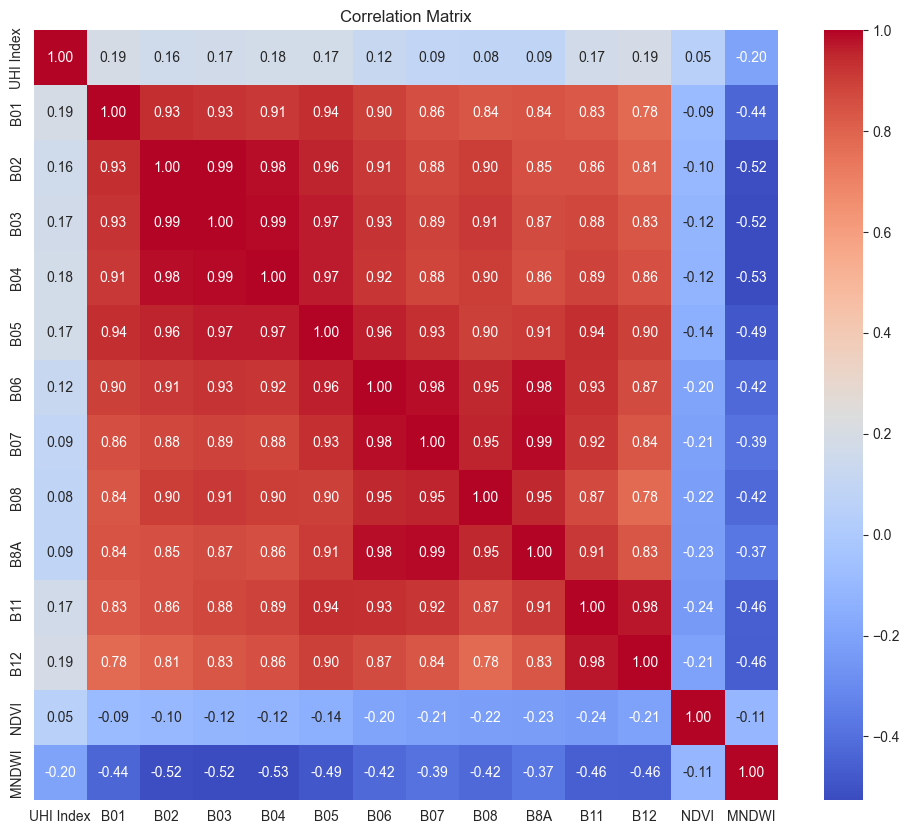

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset = pd.read_csv("../data/training_data_with_features.csv")
dataset = dataset.drop(columns=["datetime",
                                "longitude",
                                "latitude",
                                "Latitude",
                                "Longitude",
                                "distance",
                                "time",
                                "spatial_ref"])
plt.figure(figsize=(12, 10))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [3]:
eval_df = pd.read_csv("../data/evaluation_models.csv")

In [4]:
eval_df

,Model,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mape,Fold,Classification
0,ExtraTreesRegressor,0.665484,0.667421,0.009362,1.896881,0.596916,3.0,poor
1,RandomForestRegressor,0.635188,0.637301,0.009777,6.823254,0.693112,3.0,poor
2,BaggingRegressor,0.583842,0.586252,0.010440,0.698495,0.735788,3.0,poor
3,LGBMRegressor,0.414796,0.418185,0.012384,0.047391,0.968972,3.0,poor
4,HistGradientBoostingRegressor,0.411860,0.415266,0.012415,0.137986,0.969619,3.0,poor
5,DecisionTreeRegressor,0.351072,0.354830,0.013037,0.111260,0.751648,3.0,poor
6,GradientBoostingRegressor,0.248473,0.252825,0.014035,2.047084,1.113690,3.0,poor
7,KNeighborsRegressor,0.234848,0.239279,0.014161,0.053457,1.085574,3.0,poor
8,NuSVR,0.210442,0.215014,0.014385,3.132753,1.139086,3.0,poor
9,ExtraTreeRegressor,0.181840,0.186578,0.014643,0.024212,0.876151,3.0,poor
